# Creating your own EOF code
#### by Elizabeth Barnes

Demonstration of how to code up EOF analysis from start to finish.

In [119]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

#.............................................
# IMPORT STATEMENTS
#.............................................
import numpy as np
import matplotlib.pyplot as plt
import importlib
import scipy.stats as stats
import numpy.linalg as LA
import scipy.io as sio

#from mpl_toolkits.basemap import Basemap

from matplotlib.patches import Polygon
import matplotlib as mpl
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
#-------------------------------------------------------
# set figure defaults
linewidth_default = 2.0
fig_text_default = 18.
fig_title_default = fig_text_default*1.5

plt.rc('lines', linewidth=linewidth_default)    
plt.rc('text', usetex=False)
plt.rc('font', size=fig_text_default, weight='normal',family='sans-serif')
plt.rc('axes',titlesize=fig_title_default,titleweight='bold')
mpl.rcParams['figure.dpi'] = 100
#mpl.rcParams['xtick.labelsize'] = fig_text_default


This is a place for user input. Which EOF do you want to plot?

In [120]:
#-------------------------------------
# which EOF do you want to plot?
eof_num = 2
#-------------------------------------

### Data Description

This data is composed of 7 weather variables averaged over one year for each state in the US (thus, 50 states). There is also an option to comment this out and instead use a matrix of random data (just for comparison).

In [121]:
# names of the different variables for each state
descriptor_names = ['temp','precip','% sun','sun hours','clear dys','humid AM','humid PM']

# load the data
DATA = sio.loadmat('data/state_data_raw.mat')
Y = DATA['X']

# UNCOMMENT if you want to use RANDOM data
#Y = np.random.rand(np.size(Y,axis=0),np.size(Y,axis=1))

### Process your data into anomalies and decide whether to standardize or not

One decision you need to make is whether you wish to standardize your data. In this example, the 7 weather variables all have very different units. Thus, if you don't standardize your data the variable with the largest units will likely dominate the EOF calculation - and this is obviously not what we want. So, I standardize. However, note you can uncomment one of the lines if you want to see what happens when you do not standardize.

In [122]:
# calculate anomalies from the state-mean (sample-mean) - call this "X"
Ymean = np.nanmean(Y,axis = 0)
X = Y - Ymean

In [123]:
# standardize the data - call it "Xw"
Xstd = np.nanstd(X,axis = 0)
Xw = X/Xstd

# UNCOMMENT if you don't want to standardize the data
#Xw = X;

### Calculate EOF using temporal covariance matrix (covariance along the sampling dimension)

In [124]:
# define my own dot product function for when there are NaNs. 
# Note that this does the scaling by 1/M inside it (by taking nanmean), so not a true dot product.
def nandot(X,Y):
    
    C = np.empty([np.size(X,axis=0),np.size(Y,axis=1)])
    for row in np.arange(0,np.size(X,axis=0)):
        for col in np.arange(0,np.size(Y,axis=1)):
            C[row,col] = np.nanmean(np.multiply(X[row,:],Y[:,col]))
            
    return C

In [125]:
# If No NaNs: calculate the temporal covariance matrix, dimensions should be [7 x 7]
#C = 1./np.size(Xw,axis = 0)*np.dot(np.transpose(Xw),Xw) 

# If there ARE NaNs:
# calculate the scaled temporal covariance matrix by hand to ignore the NaNs, dimensions should be [7 x 7]
C = nandot(np.transpose(Xw),Xw) 

print(C)

[[ 1.          0.54408661  0.4414842   0.32948218  0.37458539  0.21872046
  -0.10306989]
 [ 0.54408661  1.         -0.33037555 -0.47090245 -0.39337431  0.64439514
   0.5403986 ]
 [ 0.4414842  -0.33037555  1.          0.9785408   0.89338975 -0.59804246
  -0.81286433]
 [ 0.32948218 -0.47090245  0.9785408   1.          0.92730696 -0.61577507
  -0.86866918]
 [ 0.37458539 -0.39337431  0.89338975  0.92730696  1.         -0.52428887
  -0.77892432]
 [ 0.21872046  0.64439514 -0.59804246 -0.61577507 -0.52428887  1.
   0.7324305 ]
 [-0.10306989  0.5403986  -0.81286433 -0.86866918 -0.77892432  0.7324305
   1.        ]]


In [126]:
# calculate eigenvalues and eigenvectors of C; lam should be 7x1, E should be 7x7
lam, E = LA.eig(C) 

# sort eigenvalues and vector by the largest to smallest eigenvalues
i = np.flipud(np.argsort(lam))
lam = lam[i]
E = E[:,i]

In [127]:
# convert eigenvalues to percent variance explained
pve = 100.*lam/np.sum(lam)

### Calculate PC timeseries and scaled EOF (called "d")

In [128]:
# take only one eigenvector, user specified by "eof_num" above
e1 = E[:,eof_num-1] #e1 should be 7x1 or 1x7 depending on your software

# calculate the the PC associated with the EOF of interest
z1 = np.dot(Xw,e1) #z1 should be 50x1 or 1x50 depending on your software

# standardize z1
z1 = (z1-np.nanmean(z1))/np.nanstd(z1)

# calculate d1 for plotting in physical units, not standardized/weighted units,
# thus it uses the original "X" anomaly data

#if no NaNs in data, I could use this
#d1 = (1./np.size(X,axis=0))*np.dot(np.transpose(z1),X)
# If there ARE NaNs:
d1 = nandot(np.matrix(z1),X).T

# calculate d1 for plotting in standardized/weighted units,
# thus it uses the "Xw" anomaly data

# If no NaNs in data, I could use this
# d1s = (1./np.size(Xw, axis = 0))*np.dot(np.transpose(z1),Xw)
# If there ARE NaNs:
d1s = nandot(np.matrix(z1),Xw).T

### Plot the results: eigenvalue spectrum

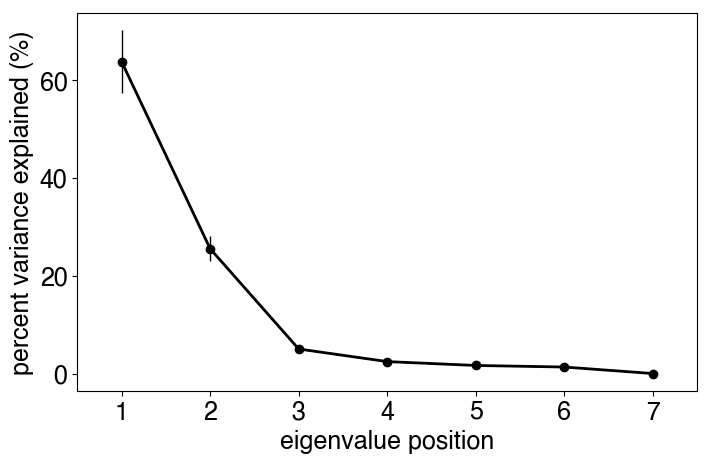

In [129]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1,np.size(pve)+1.),pve,'o-',linewidth = 2, color = 'black')

plt.xlim(0.5, 7.5)
plt.xlabel('eigenvalue position')
plt.ylabel('percent variance explained (%)')

# plot error bars according to North et al.abs
# here we will assume that all of the data is independent (is that a good assumption?)
# such that Nstar = N
Nstar = np.size(X,axis = 0)
eb = pve*np.sqrt(2./Nstar)
plt.errorbar(np.arange(1,np.size(pve)+1.),pve,yerr = eb/2, xerr = None, linewidth = 1, color = 'black')

plt.show()

### Plot the results: EOF in standardized units

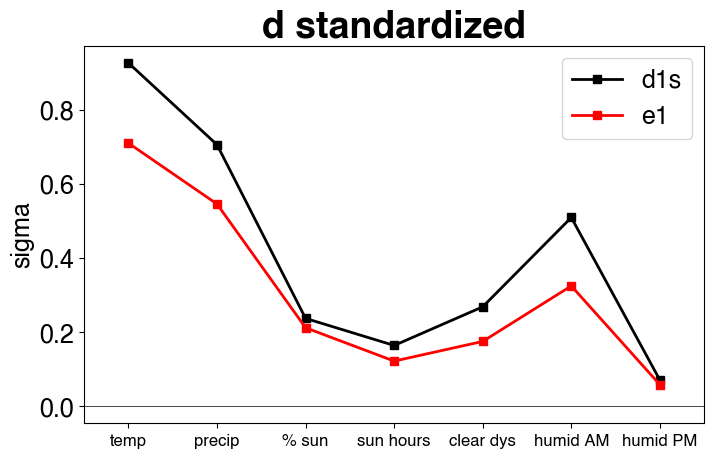

In [130]:
plt.figure(figsize=(8,5))

plt.plot(d1s,'s-k',linewidth = 2, label = 'd1s')
plt.plot(e1,'s-r',linewidth = 2, label = 'e1')

plt.xticks(np.arange(len(descriptor_names)),descriptor_names, fontsize = 12)
plt.xlim(-0.5, 6.5)

plt.legend()
plt.axhline(color='k',linewidth=.5)
plt.ylabel('sigma')
plt.title('d standardized')

plt.show()

### Plot the results: EOF in physical units

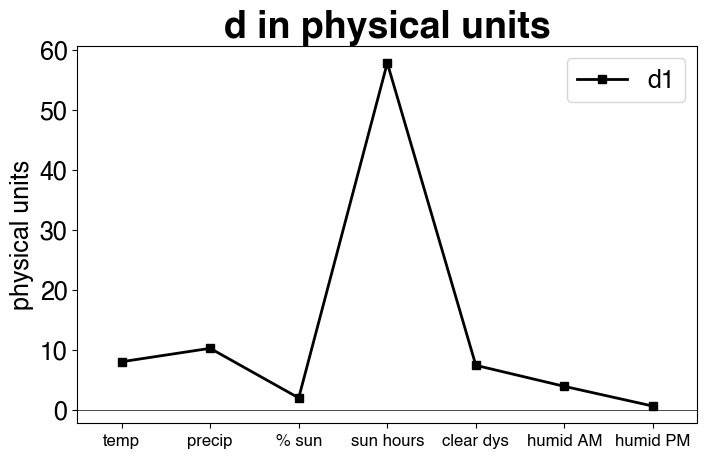

In [131]:
plt.figure(figsize=(8,5))
plt.plot(d1,'s-k',linewidth = 2, label = 'd1')

plt.xticks(np.arange(len(descriptor_names)),descriptor_names, fontsize = 12)
plt.axhline(color='k',linewidth=.5)
plt.legend()
plt.ylabel('physical units')
plt.title('d in physical units')
plt.xlim(-0.5, 6.5)

plt.show()

### Plot the results: PC as a U.S. map

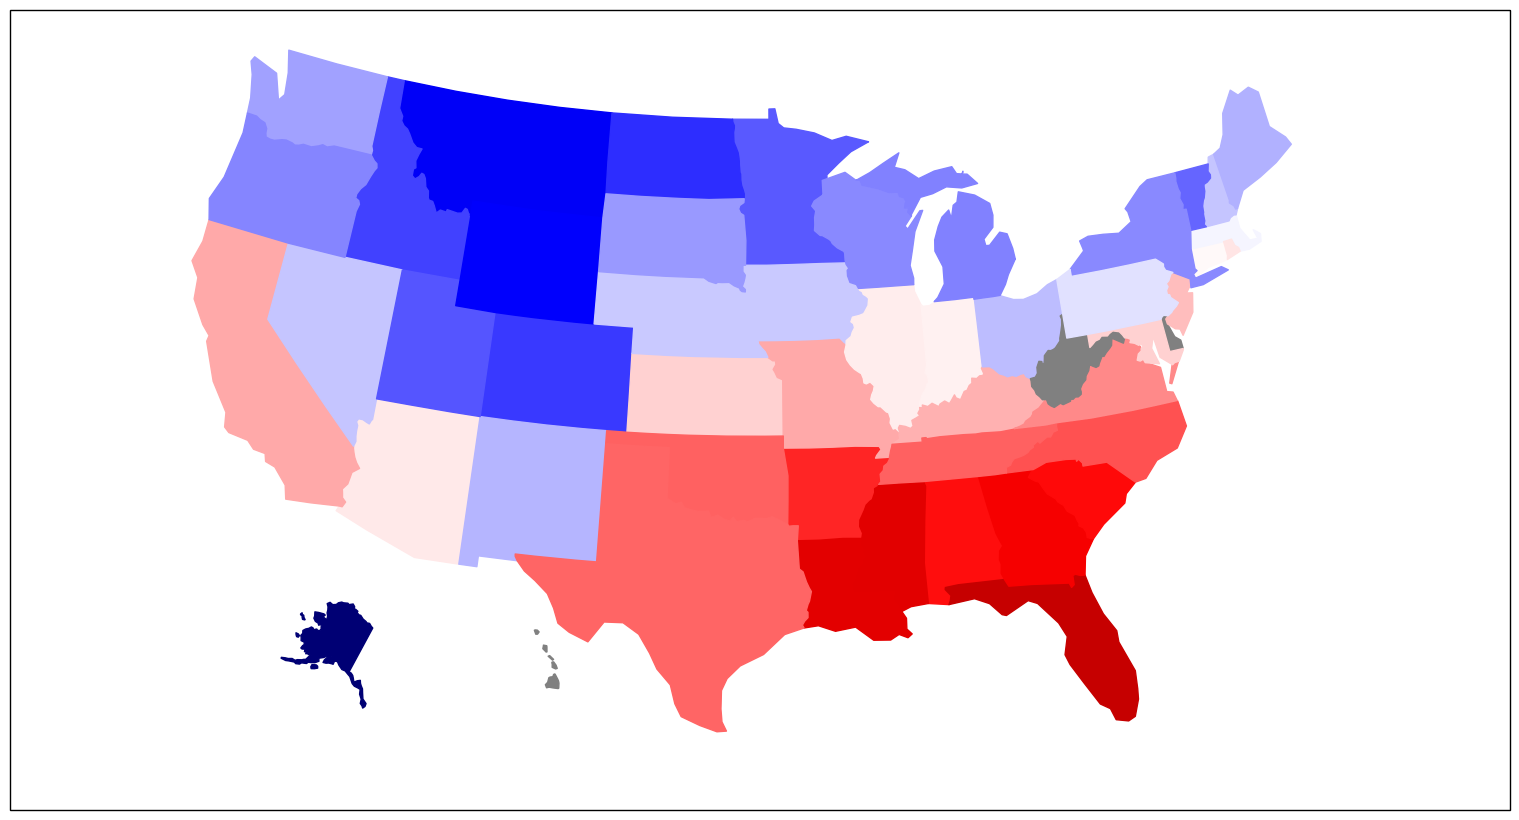

In [132]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())

ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)
state_names = []
colors={}
cmap = plt.cm.get_cmap('seismic')
vmin = -3.
vmax = 3.

for astate in shpreader.Reader(states_shp).records():
    state_names.append(astate.attributes['name'])

state_names_list = sorted(list(set(state_names)))
state_names_list.pop(state_names_list.index('District of Columbia'))

for astate in shpreader.Reader(states_shp).records():
    
    statename = astate.attributes['name']
    if(statename == 'District of Columbia'):
       continue
    # use the name of this state to get pop_density
    z = z1[state_names_list.index(statename)]
    clr = cmap((z-vmin)/(vmax-vmin))[:3]
    if(np.isnan(z)):
        clr = 'gray'
    
    if statename == 'Alaska':
    # Alaska is too big. Scale it down to 35% first, then transate it. 
        axak = fig.add_axes([0.1, 0.1, 0.2, 0.2], projection=ccrs.LambertConformal())
        axak.set_extent([-185, -130, 70, 50])
        axak.add_geometries([astate.geometry], ccrs.PlateCarree(),
                  facecolor=clr, edgecolor=clr)
    elif statename == 'Hawaii':
        axhi = fig.add_axes([0.25, .1, 0.15, 0.15], projection=ccrs.LambertConformal())
        axhi.set_extent([-155, -165, 20, 15])
        axhi.add_geometries([astate.geometry], ccrs.PlateCarree(),
                  facecolor=clr, edgecolor=clr)
    else:        
        # `astate.geometry` is the polygon to plot
        ax.add_geometries([astate.geometry], ccrs.PlateCarree(),
                          facecolor=clr, edgecolor=clr)

plt.box(False)
for subplot in [axak, axhi]:
    subplot.background_patch.set_visible(False)
    subplot.outline_patch.set_visible(False)
    
plt.show()


These PC values show how much a given state "looks" like the EOF structure above. Dark blue and dark red denote large opposite signed values (remember, the sign itself doesn't matter here - just the relationships between values/signs across states).